# EXPLORATORY DATA ANALYSIS (I.)

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

In [2]:
KEYS = [
    'entity_id',
    'financial_report_id',
    'financial_statement_id',
    'entity_ico',
    'entity_name']

DIMENSIONS = [
    'year',
    # 'month',
    # 'financial_report_order_number',
    'period_length',
    # 'consolidated',
    # 'approved_date',
    'type',
    'financial_report_template_id',
    # 'establishment_date',
    # 'cancellation_date',
    # 'sknace_code',
    # 'entity_state',
    'legal_form_code',
    'org_size_code',
    'ownership_category_code',
    'entity_consolidated',
    # 'sknace_division_name',
    'sknace_division',
    # 'sknace_subcategory',
    'sal_class',
    'is_mahalanobis_outlier',
    'is_z_score_outlier',
    'is_isolation_forest_outlier']




RATIOS = ['L1',
       'L2', 'L3', 'NCL_CF', 'CASH_TA', 'INV_COGS', 'CC_SAL', 'TL_COST',
       'CL_COST', 'SAL_TA', 'EQ_TA', 'EQ_TL', 'CL_CC', 'LTC_NCA', 'TZ',
       'CF_TL', 'CL_TA', 'NCL_TA', 'EBT_REV', 'ROS', 'EAT_REV', 'ROA', 'ROE',
       'CF_TA', 'CF_SAL', 'LABOR_EAT', 'LABOR_REV']
PRIMARY_VALUES = [
    'CA', 'CASH',
       'CL', 'EQ', 'NCL', 'TA', 'TL', 'CC', 'INV', 'CF_NETTO', 'CF_SELFFIN',
       'REV', 'VA', 'OE', 'EAT', 'EBIT', 'SAL', 'COST', 'INT'
]



DISTRESS_SIGNALS = [
    'DPHZ_vat_registration_cancelled',
    'DPHZ_vat_registration_cancelled_1y_off',
    'DPHZ_vat_registration_cancelled_2y_off',
    'DPHZ_vat_registration_cancelled_3y_off',
    'RU_event',
    'RU_event_1y_off',
    'RU_event_2y_off',
    'RU_event_3y_off',
    'cancellation_year',
    'RUZ_cancelled',
    'RUZ_cancelled_1y_off',
    'RUZ_cancelled_2y_off',
    'RUZ_cancelled_3y_off']

In [3]:
data_raw = pd.read_csv('../../DATA/FINAL/super_sample.csv')
data_raw

,entity_id,year,month,financial_report_id,financial_report_template_id,CA,CASH,CL,EQ,NCL,TA,TL,CC,INV,CF_NETTO,CF_SELFFIN,REV,VA,OE,EAT,EBIT,SAL,COST,INT,LABOR,L1,L2,L3,NCL_CF,CASH_TA,INV_COGS,CC_SAL,TL_COST,CL_COST,SAL_TA,EQ_TA,EQ_TL,CL_CC,LTC_NCA,TZ,CF_TL,CL_TA,NCL_TA,EBT_REV,ROS,EAT_REV,ROA,ROE,CF_TA,CF_SAL,LABOR_EAT,LABOR_REV,financial_statement_id,financial_report_order_number,entity_ico,period_length,consolidated,approved_date,type,entity_name,establishment_date,cancellation_date,sknace_code,entity_state,legal_form_code,org_size_code,ownership_category_code,entity_consolidated,sknace_division_name,sknace_division,sknace_subcategory,DPHZ_vat_registration_cancelled,DPHZ_vat_registration_cancelled_1y_off,DPHZ_vat_registration_cancelled_2y_off,DPHZ_vat_registration_cancelled_3y_off,RU_event,RU_event_1y_off,RU_event_2y_off,RU_event_3y_off,cancellation_year,RUZ_cancelled,RUZ_cancelled_1y_off,RUZ_cancelled_2y_off,RUZ_cancelled_3y_off,sal_class,establishment_year,is_mahalanobis_outlier,is_z_score_outlier,is_isolation_forest_outlier,RUZ_indirect_criteria,RUZ_indirect_criteria_1y_off,RUZ_indirect_criteria_2y_off,RUZ_indirect_criteria_3y_off,combined_issue_criteria_1y_off,combined_issue_criteria_2y_off,combined_issue_criteria_3y_off,plausible_sample
0,27971.0,2018.0,1.0,6791492,699.0,824851.0,137120.0,564418.0,17376.0,46374.0,875393.0,846466.0,673298.0,11072.0,13087.0,9028.0,3031970.0,260410.0,24567.0,2651.0,6710.0,3031963.0,3007396.0,8218.0,370870.0,0.242941,1.435847,1.455464,3.543516,0.156638,NaN,0.222067,0.281461,0.187677,3.463545,0.019849,0.020115,0.838289,5.924261,1.908459,0.015461,0.644760,0.052975,0.002213,0.000874,0.000874,0.003028,0.152567,0.014950,0.004316,139.898152,0.122320,4101516.0,1.0,652423.0,12.0,NaN,2019-06-28,Riadna,KUHO - mix. spol. s r.o.,1991-06-25,NaN,49410.0,NaN,112.0,2.0,2.0,False,Pozemná doprava a doprava potrubím,H,49.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN,0,0,0,0,2. Malý,1991,False,True,False,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,60314.0,2016.0,1.0,5545966,699.0,58815.0,15639.0,56837.0,127982.0,76345.0,2248496.0,1745181.0,23576.0,18552.0,2741491.0,2731211.0,3322652.0,199899.0,-472509.0,2073411.0,2079171.0,692195.0,1164704.0,1958.0,224570.0,0.275155,0.689955,1.016363,0.027848,0.006955,2.734670,0.034060,1.498390,0.048800,0.307848,0.056919,0.068324,2.410799,0.829493,0.615510,1.570892,0.025278,0.033954,0.625756,2.995415,0.624023,0.922132,16.200802,1.219255,3.960576,0.108309,0.067588,3090140.0,1.0,36589993.0,12.0,NaN,NaN,Riadna,Pivovar Kaltenecker s.r.o.,2005-02-22,2021-06-24,11050.0,NaN,112.0,0.0,8.0,False,Výroba nápojov,C,11.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2021.0,0,0,0,0,2. Malý,2005,True,True,True,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2,71752.0,2015.0,1.0,5058691,699.0,912862.0,2213.0,48840.0,2399.0,18406.0,948368.0,945969.0,910649.0,0.0,-35846.0,-38726.0,2179262.0,-27686.0,-68089.0,-57122.0,-54242.0,2134583.0,2202672.0,67110.0,12114.0,0.045311,18.690868,18.690868,-0.513474,0.002333,0.000000,0.426617,0.429464,0.022173,2.250796,0.002530,0.002530,0.053632,25.334535,-0.923590,-0.037893,0.051499,0.019408,-0.024890,-0.026760,-0.026212,-0.060232,-23.810754,-0.037798,-0.016793,-0.212072,0.005559,2703097.0,1.0,36584649.0,12.0,NaN,2016-03-10,Riadna,FeCom s.r.o.,2004-10-08,NaN,46720.0,NaN,112.0,0.0,8.0,False,"Veľkoobchod, okrem motorových vozidiel a motoc...",G,46.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN,0,0,0,0,2. Malý,2004,False,True,False,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
3,72912.0,2017.0,1.0,6351388,699.0,1481047.0,1630.0,1326396.0,-718007.0,549510.0,1521883.0,2239890.0,1417869.0,61548.0,47298.0,44418.0,4512573.0,802511.0,52068.0,10312.0,13192.0,4512342.0,4460274.0,32121.0,692228.0,0.001229,1.070192,1.116595,11.618039,0.001071,NaN,0.314220,0.502187,0.297380,2.964973,-0.471789,-0.471789,0.935486,4.787124,16.043871,0.021116,0.871549,0.361072,0.002923,0.002285,0.002285,0.006776,-0.014362,0.031079,0.010482,67.128394,0.153400,3748560.0,1.0,35904798.0,12.0,NaN,2018-06-21,Riadna,"WETRON, s.r.o.",2004-10-23,NaN,33200.0,NaN,112.0,0.0,

## 1. Struktura udajov z pohladu velkostnej kategorie, oblasti zamerania etc.

In [4]:
data = data_raw.query('is_mahalanobis_outlier == False and is_z_score_outlier == False and is_isolation_forest_outlier == False and financial_report_template_id == 699')

In [5]:
display(data.info())
display(data[RATIOS].describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6439 entries, 4 to 9522
Data columns (total 97 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   entity_id                               6439 non-null   float64
 1   year                                    6439 non-null   float64
 2   month                                   6439 non-null   float64
 3   financial_report_id                     6439 non-null   int64  
 4   financial_report_template_id            6439 non-null   float64
 5   CA                                      6439 non-null   float64
 6   CASH                                    6439 non-null   float64
 7   CL                                      6439 non-null   float64
 8   EQ                                      6439 non-null   float64
 9   NCL                                     6439 non-null   float64
 10  TA                                      6439 non-null   floa

None

,L1,L2,L3,NCL_CF,CASH_TA,INV_COGS,CC_SAL,TL_COST,CL_COST,SAL_TA,EQ_TA,EQ_TL,CL_CC,LTC_NCA,TZ,CF_TL,CL_TA,NCL_TA,EBT_REV,ROS,EAT_REV,ROA,ROE,CF_TA,CF_SAL,LABOR_EAT,LABOR_REV
count,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,4.788000e+03,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6436.000000,6361.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000
mean,0.449871,1.591130,2.139198,0.669096,0.122081,6.043558e+02,0.207520,0.602243,0.260669,2.605930,0.339162,0.344557,5.471756,121.730287,0.185302,0.300167,0.455709,0.059297,0.043572,0.034451,0.033363,0.068016,0.142326,0.135068,0.077442,15.769442,0.122184
std,1.248735,2.471997,2.841744,6.859142,0.154573,3.199081e+04,0.358494,3.557051,0.362312,2.319366,0.253073,0.255579,91.298594,3997.941671,15.222365,0.428204,0.261556,0.126672,0.069316,0.081028,0.057839,0.100240,3.230933,0.128309,0.107197,252.558076,0.131218
min,0.000000,0.001501,0.015903,-265.725010,0.000000,-1.682500e+01,0.000000,0.008763,0.002636,0.000000,-1.673241,-1.686893,0.012381,-483.386667,-412.067684,-2.377166,0.002064,0.000000,-0.407883,-1.176163,-0.373383,-0.673779,-250.664306,-0.660441,-1.147023,-1300.495265,-0.001245
25%,0.035021,0.729953,1.073450,0.007985,0.013499,5.116392e-02,0.091854,0.184941,0.122721,1.372096,0.155133,0.157601,0.761774,1.084329,-1.914996,0.075396,0.247941,0.001389,0.007494,0.005131,0.005118,0.011203,0.039476,0.052674,0.022902,0.571453,0.034068
50%,0.145581,1.133523,1.481016,0.078380,0.058532,2.158576e-01,0.157509,0.291576,0.194414,2.094788,0.309977,0.315240,1.154473,1.815301,-0.358307,0.173509,0.424973,0.010491,0.025742,0.019887,0.019847,0.042314,0.149058,0.106185,0.051514,2.544904,0.084308
75%,0.457813,1.776309,2.328838,0.503257,0.171844,1.210587e+00,0.250754,0.480454,0.305924,3.223292,0.516215,0.527329,1.980479,4.338650,1.836370,0.359016,0.637672,0.052937,0.063401,0.049964,0.049712,0.101971,0.345624,0.185536,0.105660,7.606437,0.163556
max,41.365349,122.137319,122.137319,168.325646,0.942293,2.208397e+06,15.891720,244.942548,13.387313,74.571396,0.981254,0.981254,4853.333984,242128.000000,448.771403,7.633007,2.618233,2.294684,0.598564,3.387539,0.586467,0.725881,10.095223,1.181596,3.506401,14319.272727,0.938168


In [6]:
# dim ='sknace_division'

# summary_table = (
#     pd.concat(
#         [
#             data.query('RU_event_3y_off == 0').groupby([dim])['financial_statement_id'].nunique().to_frame('I0'),
#             data.query('RU_event_3y_off == 1').groupby([dim])['financial_statement_id'].nunique().to_frame('I1'),

#             data.query('RUZ_cancelled_3y_off == 0').groupby([dim])['financial_statement_id'].nunique().to_frame('C0'),
#             data.query('RUZ_cancelled_3y_off == 1').groupby([dim])['financial_statement_id'].nunique().to_frame('C1'),

#             data.query('RUZ_indirect_criteria_3y_off == 0').groupby([dim])['financial_statement_id'].nunique().to_frame('L0'),
#             data.query('RUZ_indirect_criteria_3y_off == 1').groupby([dim])['financial_statement_id'].nunique().to_frame('L1'),

#             data.query('combined_issue_criteria_3y_off == 0').groupby([dim])['financial_statement_id'].nunique().to_frame('FD1'),
#             data.query('combined_issue_criteria_3y_off == 1').groupby([dim])['financial_statement_id'].nunique().to_frame('FD1'),
#             data.groupby([dim])['financial_statement_id'].nunique().to_frame('Spolu'),
#         ], axis = 1
#     ).reset_index()
# )
# # display(summary_table)
# # for col in summary_table.columns[2:]:
# #     # summary_table[col] = summary_table[col].fillna(0)
# #     summary_table[col] = pd.to_numeric(summary_table[col]).fillna(0).apply(lambda x: int(x))

# summary_table['Podiel I1'] = summary_table['I1'] / summary_table['Spolu']
# summary_table['Podiel C1'] = summary_table['C1'] / summary_table['Spolu']
# summary_table['Podiel L1'] = summary_table['L1'] / summary_table['Spolu']
# summary_table['Podiel FD1'] = summary_table['FD1'] / summary_table['Spolu']

# summary_table[['sknace_division', 'Podiel I1', 'Podiel C1', 'Podiel L1', 'Podiel FD1', 'Spolu']]

In [7]:
display(data_raw['RU_event_3y_off'].value_counts(normalize=True))
display(data['RU_event_3y_off'].value_counts(normalize=True))

0.0    0.975218
1.0    0.024782
Name: RU_event_3y_off, dtype: float64

0.0    0.978257
1.0    0.021743
Name: RU_event_3y_off, dtype: float64

In [8]:
display(data_raw.shape[0])
display(data.shape[0])

display(data_raw[RATIOS].describe().T)
display(data[RATIOS].describe().T)

9523

6439

,count,mean,std,min,25%,50%,75%,max
L1,9519.0,15.448318,1269.658661,0.000000,0.035819,0.165205,0.578863,1.237488e+05
L2,9519.0,22.153260,1280.816611,0.000244,0.727278,1.177129,2.093605,1.237488e+05
L3,9519.0,23.205409,1281.239454,0.000361,1.044797,1.516195,2.702955,1.237488e+05
NCL_CF,9522.0,1.936758,100.064898,-5842.686851,0.003922,0.060947,0.548962,4.994496e+03
CASH_TA,9523.0,0.138474,0.185229,0.000000,0.012475,0.060618,0.190107,1.421181e+00
INV_COGS,6708.0,442.666371,27028.537925,-16.825000,0.037182,0.202614,1.265615,2.208397e+06
CC_SAL,9488.0,4122.508109,400681.857649,0.000000,0.084162,0.156793,0.268326,3.902896e+07
TL_COST,9519.0,78.608077,3695.771790,0.000000,0.176463,0.305595,0.562514,2.766460e+05
CL_COST,9519.0,72.224364,3676.313653,0.000000,0.112287,0.193584,0.332162,2.766460e+05
SAL_TA,9523.0,4.803637,97.906297,0.000000,1.128127,1.957284,3.223292,9.265284e+03


,count,mean,std,min,25%,50%,75%,max
L1,6439.0,0.449871,1.248735,0.000000,0.035021,0.145581,0.457813,4.136535e+01
L2,6439.0,1.591130,2.471997,0.001501,0.729953,1.133523,1.776309,1.221373e+02
L3,6439.0,2.139198,2.841744,0.015903,1.073450,1.481016,2.328838,1.221373e+02
NCL_CF,6439.0,0.669096,6.859142,-265.725010,0.007985,0.078380,0.503257,1.683256e+02
CASH_TA,6439.0,0.122081,0.154573,0.000000,0.013499,0.058532,0.171844,9.422933e-01
INV_COGS,4788.0,604.355786,31990.808788,-16.825000,0.051164,0.215858,1.210587,2.208397e+06
CC_SAL,6439.0,0.207520,0.358494,0.000000,0.091854,0.157509,0.250754,1.589172e+01
TL_COST,6439.0,0.602243,3.557051,0.008763,0.184941,0.291576,0.480454,2.449425e+02
CL_COST,6439.0,0.260669,0.362312,0.002636,0.122721,0.194414,0.305924,1.338731e+01
SAL_TA,6439.0,2.605930,2.319366,0.000000,1.372096,2.094788,3.223292,7.457140e+01


In [9]:
display(data.shape)

(6439, 97)

In [10]:
def get_sample_sizes(data, row_label, column_label):
    samples_df = data.groupby([row_label, column_label])['financial_statement_id'].nunique().to_frame('count').reset_index()
    wide_df = pd.pivot_table(samples_df, index = row_label, columns=column_label, fill_value=0).reset_index()
    return wide_df

In [11]:
get_sample_sizes(data, 'year', 'combined_issue_criteria_3y_off')

year count     
combined_issue_criteria_3y_off           0.0  1.0
0                               2015.0  1417  262
1                               2016.0  1354  160
2                               2017.0  1380  122
3                               2018.0  1593  151

In [12]:
get_sample_sizes(data, 'year', 'RUZ_indirect_criteria_3y_off')

year count     
RUZ_indirect_criteria_3y_off           0.0  1.0
0                             2015.0  1575  104
1                             2016.0  1426   88
2                             2017.0  1416   86
3                             2018.0  1648   96

In [13]:
get_sample_sizes(data, 'year', 'RUZ_cancelled_3y_off')

year count     
RUZ_cancelled_3y_off             0    1
0                     2015.0  1542  137
1                     2016.0  1454   60
2                     2017.0  1475   27
3                     2018.0  1705   39

In [14]:
get_sample_sizes(data, 'year', 'RU_event_3y_off')

year count    
RU_event_3y_off           0.0 1.0
0                2015.0  1634  45
1                2016.0  1484  30
2                2017.0  1475  27
3                2018.0  1706  38

In [15]:
get_sample_sizes(data, 'sal_class', 'combined_issue_criteria_3y_off')

sal_class count     
combined_issue_criteria_3y_off               0.0  1.0
0                                  2. Malý  4767  598
1                               3. Stredný   977   97

In [16]:
get_sample_sizes(data, 'sknace_division', 'combined_issue_criteria_3y_off')

sknace_division count     
combined_issue_criteria_3y_off                   0.0  1.0
0                                            A   185   12
1                                            C  1303  109
2                                            F   540   69
3                                            G  2036  242
4                                            H   394   44
5                                            I    64   18
6                                            J   205   21
7                                            L   278   46
8                                            M   398   81
9                                            N   274   48
10                                           Q    67    5

## 2. Analýza distribúcie prediktorov

In [17]:
def plot_histograms(df, columns, filter_out_outliers = True, apply_arsinh_transform=False):
    # Plotting the histograms
    fig, axes = plt.subplots(nrows=int(len(columns) / 3) + 1, ncols=3, figsize=(20, 30))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        ax = axes[i]

        data = df.query(f'{column} == {column} and {column} != 0')[column]

        
        # Calculate skewness
        data_skewness = round(data.skew(), 1)

        # Apply arsinh transformation if requested
        if apply_arsinh_transform:
            data = np.arcsinh(data)
            transformation = 'Arsinh-Transformed'
        else:
            transformation = 'Original'

        # Calculate skewness
        data_skewness_new = round(data.skew(), 1)
        
        Q1 = data.quantile(0.25)
        Q2 = data.quantile(0.5)
        Q3 = data.quantile(0.75)
        
        IQR = Q3 - Q1
        
            

        bin_width = 2 * IQR / (len(data) ** (1/3))

        num_bins = min(100, int(np.ceil((np.max(data) - np.min(data)) / bin_width)))

        sns.histplot(data, bins=num_bins, kde=True, color='skyblue', edgecolor='black', ax=ax)
        # sns.kdeplot(cleaned_data, color='red', ax=ax, linewidth=2)  # Adding KDE plot
        ax.set_title(f'{column}, original skewness: {data_skewness}, transformed skewness: {data_skewness_new}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

        for color, z_score_threshold in [('red', 3), ('blue', 2)]:
            lower_bound = data.mean() - z_score_threshold * data.std()
            upper_bound = data.mean() + z_score_threshold * data.std()
            
            ax.axvline(lower_bound, color=color, linewidth=1, label=f'lower bound, threshold {z_score_threshold}')
            ax.axvline(upper_bound, color=color, linestyle='--', linewidth=1, label=f'upper bound, threshold {z_score_threshold}')

        # Add horizontal lines for quartiles and median
        ax.axvline(Q2, color='green', linestyle='-', linewidth=2, label='Median')

        # Only add legend to the first plot for clarity
        if i == 0:
            ax.legend()

    # Hide empty subplots
    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

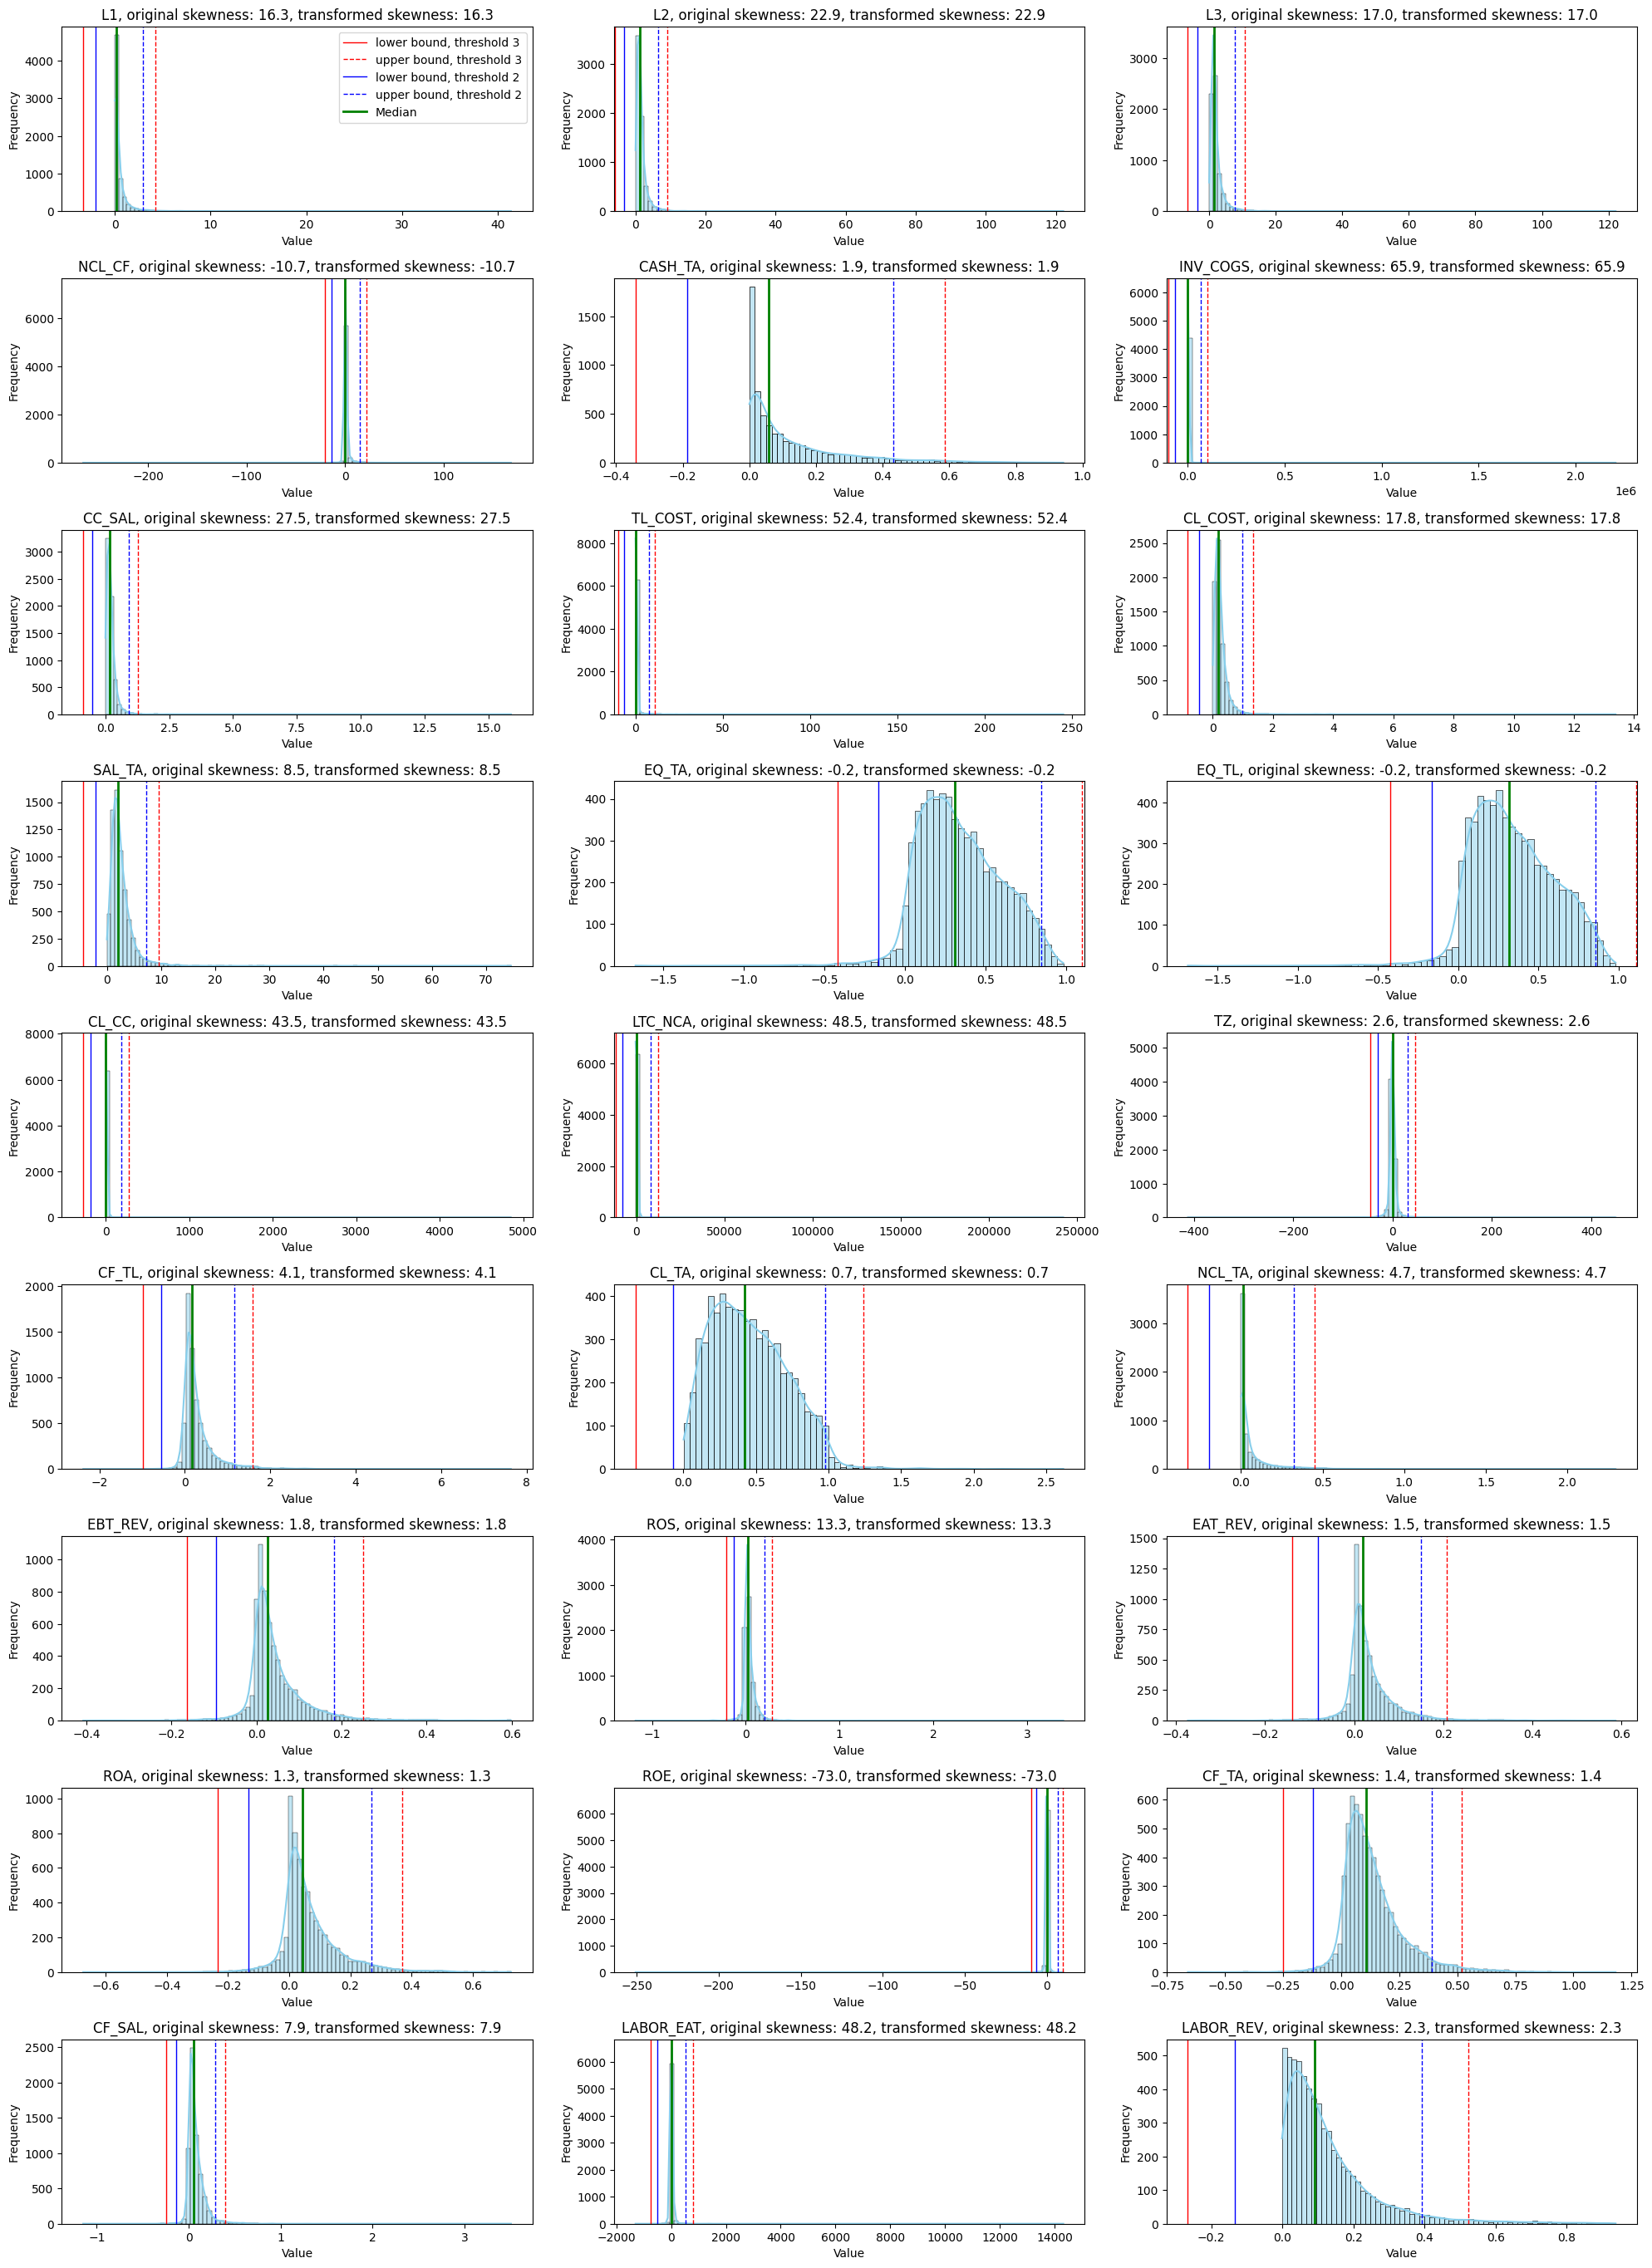

In [18]:
plot_histograms(data, RATIOS, False, False)

## 2. Analýza multikolinearity

In [19]:
Q = data.query('combined_issue_criteria_3y_off == 1').shape[0]
subset = pd.concat(
    [
        data.query('combined_issue_criteria_3y_off == 1').sample(Q),
        data.query('combined_issue_criteria_3y_off == 0').sample(Q)
    ], axis = 0
)

In [20]:
for col in RATIOS:
    mean_value = subset[col].mean()
    subset[col] = subset[col].fillna(mean_value)

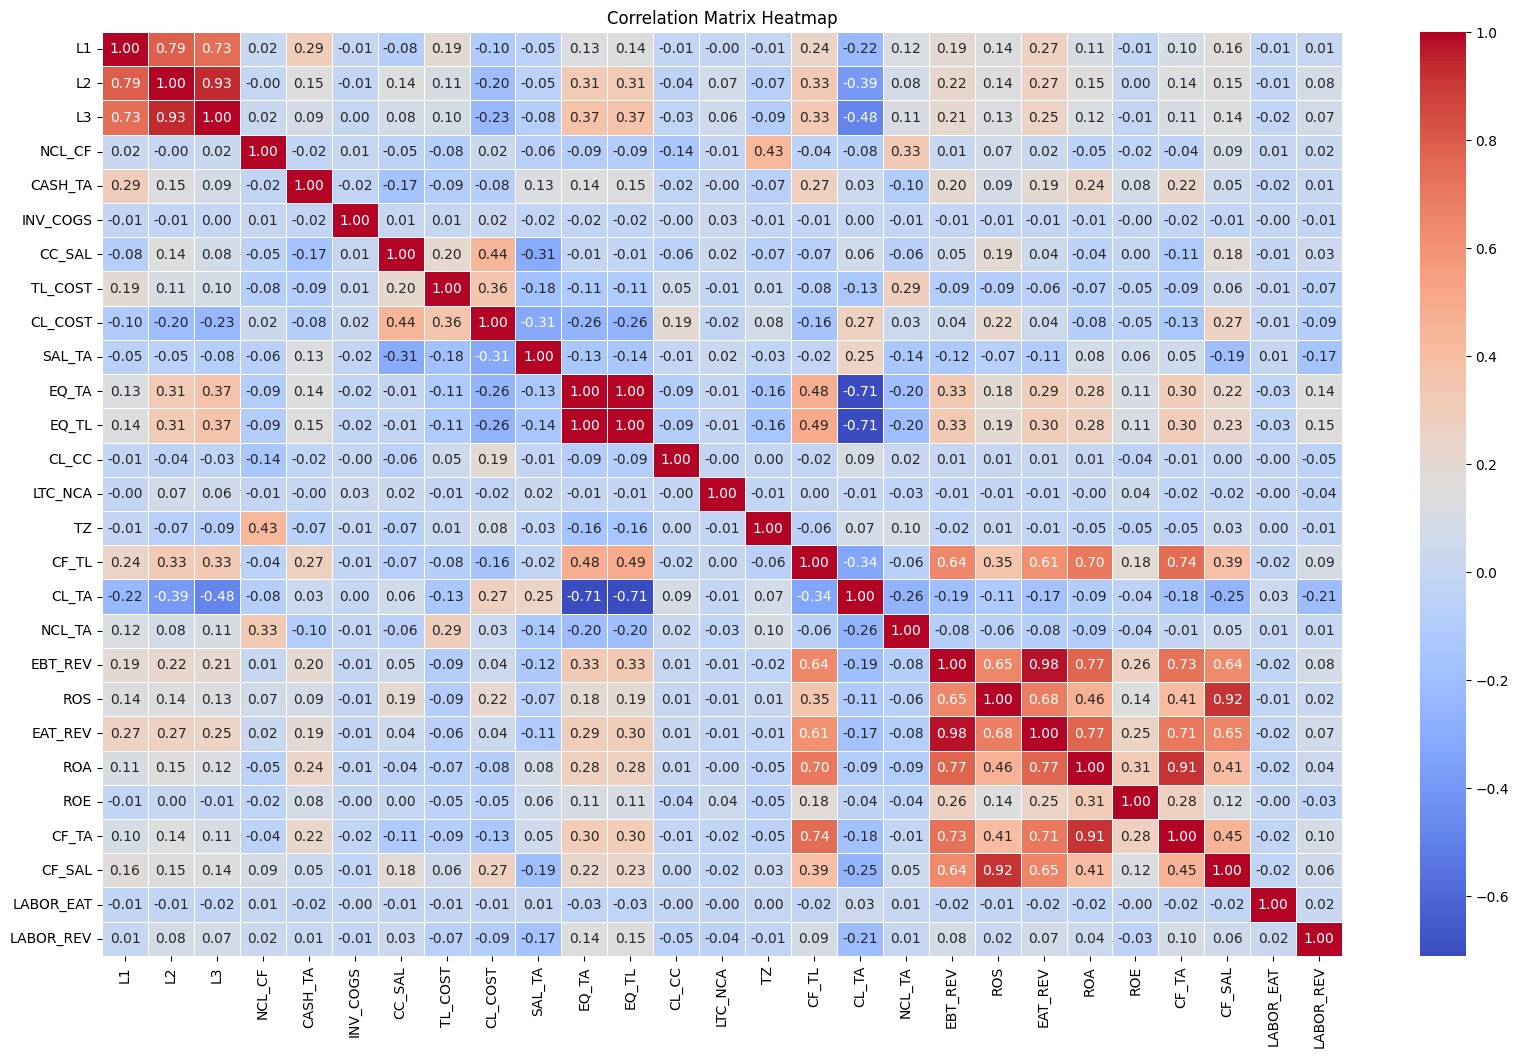

In [21]:
# Calculate the correlation matrix
correlation_matrix = subset[RATIOS].corr()

# Create a heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [22]:
len(RATIOS)

27

In [37]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df = subset[RATIOS].drop(columns = ['L2', 'EQ_TL', 'EAT_REV', 'CF_SAL', 'CF_TA']).copy()

# Adding a constant for the intercept
df_const = add_constant(df)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['feature'] = df_const.columns
vif_data['VIF'] = [variance_inflation_factor(df_const.values, i) for i in range(df_const.shape[1])]

display(vif_data)

,feature,VIF
0,const,35.225465
1,L1,3.131823
2,L3,3.569007
3,NCL_CF,1.498890
4,CASH_TA,1.348719
5,INV_COGS,1.004337
6,CC_SAL,1.635119
7,TL_COST,1.652407
8,CL_COST,2.120572
9,SAL_TA,1.473230


In [39]:
RATIOS_SUBSET = subset[RATIOS].drop(columns = ['L2', 'EQ_TL', 'EAT_REV', 'CF_SAL', 'CF_TA']).columns

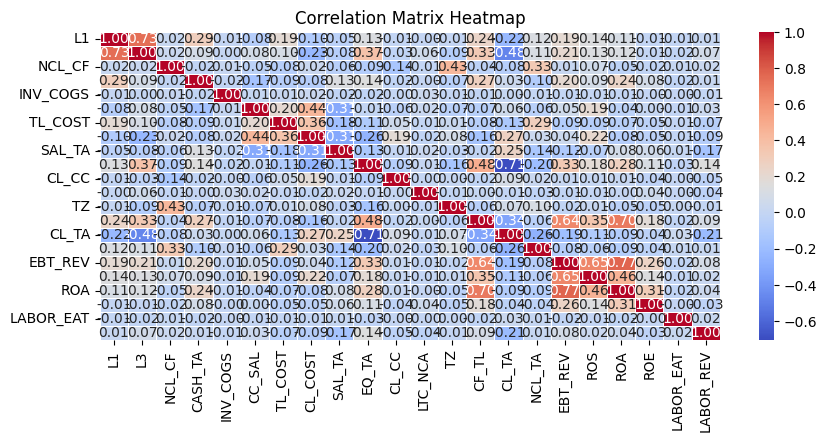

In [40]:
# Calculate the correlation matrix
correlation_matrix = subset[RATIOS_SUBSET].corr()

# Create a heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [41]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df = subset[RATIOS_SUBSET].copy()

# Adding a constant for the intercept
df_const = add_constant(df)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['feature'] = df_const.columns
vif_data['VIF'] = [variance_inflation_factor(df_const.values, i) for i in range(df_const.shape[1])]

display(vif_data)

,feature,VIF
0,const,35.225465
1,L1,3.131823
2,L3,3.569007
3,NCL_CF,1.498890
4,CASH_TA,1.348719
5,INV_COGS,1.004337
6,CC_SAL,1.635119
7,TL_COST,1.652407
8,CL_COST,2.120572
9,SAL_TA,1.473230


In [42]:
from scipy.stats import shapiro

def check_normality(dataframe):
    # Dictionary to store the results
    results = {}

    # Loop through each column in the DataFrame
    for column in dataframe.columns:
        # Skip columns with non-numeric data
        if dataframe[column].dtype.kind not in 'biufc':
            continue
        
        # Perform Shapiro-Wilk test on the column
        stat, p_value = shapiro(dataframe[column].dropna())  # Drop NA values for the test
        
        # Store the result in the dictionary
        results[column] = {'Statistic': stat, 'P-value': p_value}

    return results


pd.DataFrame(check_normality(data[RATIOS])).T

c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Statistic,P-value
L1,0.285679,0.000000e+00
L2,0.327919,0.000000e+00
L3,0.374178,0.000000e+00
NCL_CF,0.140013,0.000000e+00
CASH_TA,0.764310,0.000000e+00
INV_COGS,0.004701,0.000000e+00
CC_SAL,0.265190,0.000000e+00
TL_COST,0.064082,0.000000e+00
CL_COST,0.355125,0.000000e+00
SAL_TA,0.626671,0.000000e+00


# 3. Overenie diskriminacnej schopnosti

In [53]:
import pandas as pd
from scipy.stats import ttest_ind, levene

# Load your dataset
# df = pd.read_csv('path_to_your_data.csv')  # Uncomment and modify this line to load your dataset

# Sample data and class division for demonstration
df = pd.DataFrame(subset[RATIOS + ['combined_issue_criteria_3y_off']])

# Separate the dataset into two classes
class0 = df[df['combined_issue_criteria_3y_off'] == 0]
class1 = df[df['combined_issue_criteria_3y_off'] == 1]

# Perform a t-test and Levene's test for each feature
results = []
for feature in df.columns[:-1]:  # Exclude the class label column
    # Levene's test for equality of variances
    stat, p_val_levene = levene(class0[feature], class1[feature])
    
    # Decide which t-test to use based on Levene's test result
    equal_var = p_val_levene > 0.05  # Assume equal variances if Levene's test is not significant
    t_stat, p_val_ttest = ttest_ind(class0[feature], class1[feature], equal_var=equal_var)

    equal_mean = p_val_ttest > 0.05
    
    results.append({
        'Feature': feature,
        'Mean 1': class0[feature].mean(),
        'Mean 2': class1[feature].mean(),
        'Levene Statistic': stat,
        'Levene P-value': p_val_levene,
        'T-statistic': t_stat,
        'T-test P-value': p_val_ttest,
        'Equal Variances Assumed': equal_var,
        'Equal Mean': equal_mean
    })

results_df = pd.DataFrame(results).sort_values('T-test P-value')
display(results_df)


,Feature,Mean 1,Mean 2,Levene Statistic,Levene P-value,T-statistic,T-test P-value,Equal Variances Assumed,Equal Mean
10,EQ_TA,0.375034,0.151604,0.873149,3.502474e-01,16.150537,6.696591e-54,True,False
11,EQ_TL,0.380653,0.154485,0.916228,3.386340e-01,16.103114,1.278334e-53,True,False
16,CL_TA,0.430650,0.636919,29.053958,8.261758e-08,-13.809062,1.224574e-40,False,False
18,EBT_REV,0.050160,0.017502,12.377665,4.485231e-04,9.265773,7.327969e-20,False,False
20,EAT_REV,0.039147,0.012326,7.630788,5.813732e-03,8.772051,5.081660e-18,False,False
23,CF_TA,0.148370,0.090333,0.177570,6.735356e-01,8.048266,1.787814e-15,True,False
15,CF_TL,0.348936,0.161498,22.623732,2.175733e-06,7.670499,3.281252e-14,False,False
21,ROA,0.078794,0.035813,0.070280,7.909688e-01,7.274685,5.785411e-13,True,False
24,CF_SAL,0.088880,0.041347,8.551117,3.509142e-03,6.937968,6.798567e-12,False,False
2,L3,2.230738,1.547709,18.772026,1.579138e-05,5.919478,4.301862e-09,False,False


## 4. Zakladne popisne statistiky

In [ ]:
subset.query('combined_issue_criteria_3y_off == 1')[RATIOS_SUBSET].describe().T

,count,mean,std,min,25%,50%,75%,max
SAL_TA,1011.0,3.837639,8.093894,0.075003,1.378678,2.229987,3.904755,146.299417
L3,1011.0,1.703794,2.391919,0.015903,0.935375,1.092780,1.612867,34.494401
ROE,1011.0,-0.514246,9.684605,-276.756757,-0.133416,0.070328,0.388657,80.193576
EAT_TA,1011.0,0.021981,0.120828,-0.755073,-0.006559,0.010963,0.053732,0.652771
TL_TA,1011.0,0.860742,0.309952,0.026637,0.703604,0.896116,0.988172,3.236349
CASH_TA,1011.0,0.109238,0.162828,0.000000,0.008850,0.039847,0.136729,1.097055
ROS,1011.0,0.005783,0.060549,-0.284867,-0.003254,0.004199,0.021108,0.301528
NCL_TA,1011.0,0.077847,0.182526,0.000000,0.000345,0.006975,0.054937,1.656374
TL_SAL,1011.0,0.580263,0.849412,0.001863,0.196682,0.368817,0.637535,10.831183
